# Backyard Bird Science with Alan

# Overview

- I set up a Wyze camera in my backyard to record activity at my bird feeder
- I'm using Facebook's Detection Transformer (DETR) to detect birds
- I've evaluated several pre-trained bird classification algorithms

# Camera Setup

- Product
  - https://www.wyze.com/products/wyze-cam
- RTSP
  - https://support.wyze.com/hc/en-us/articles/360026245231-Wyze-Cam-RTSP
- Data collection in opencv

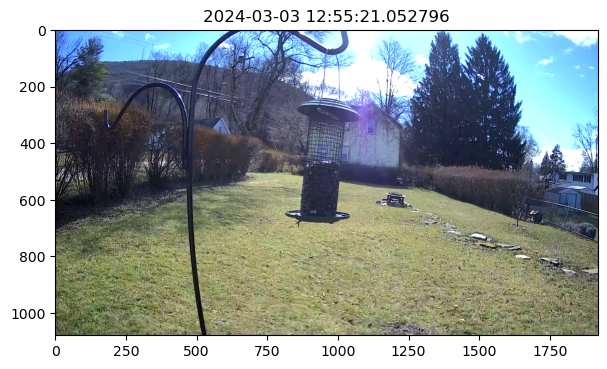

In [1]:
import cv2
import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline

# rtsp username and password are define within the wyze app
# store password in environment variables
# never hard code passwords and store on a public site such as github!
os.environ['RTSP_USERNAME'] = 'Alan'
os.environ['RTSP_PASSWORD'] = 'speedsti3'

username = os.environ['RTSP_USERNAME']
password = os.environ['RTSP_PASSWORD']

# url on local network
url = '192.168.1.176'

# rtsp connection string
rtsp = f'rtsp://{username}:{password}@{url}/live'

# video capture
cap = cv2.VideoCapture(rtsp)

# begin endless loop (always a good idea)
while True:
    # set framerate to frames per second
    time.sleep(0.5)

    # get current timestamp
    now = datetime.datetime.now()

    # read frame
    valid, frame = cap.read()

    # check for valid frame
    if valid:
        # write image to file
        cv2.imwrite(f'images/{now.strftime("%Y%m%d_%H%M%S%f")}.jpg', frame)

        # display image
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.imshow(frame[:, :, ::-1])
        ax.set_title(now)
        plt.show()
    else:
        # in case of frame read failure, attempt to reconnect 
        cap.release()
        cap = cv2.VideoCapture(rtsp)

    # break for the sake of this demo
    break
cap.release()

# Bird Detection

- To detect birds, I use [Facebook's Detection Transformer (DETR)](https://github.com/facebookresearch/detr).   
- I obtain the pretrained model from [TorchHub](https://pytorch.org/hub/)
- The DETR was trained on the [COCO Dataset](https://cocodataset.org/), which contains 92 classes (including birds!)

In [6]:
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# use the GPU to speed up model scoring
device = torch.device(0)

# download the pre-trained DETR model from torch hub
model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True).to(device)

# define a pytorch dataset for image data
class ImageSet(Dataset):
    # initialize dataset with only one day of data
    # (defined as an integer with year, month, day
    def __init__(self, dt = 20240302):
        super().__init__()
        # extract all the image files with the date string
        self.img_files = sorted(glob.glob(f'images/{dt}_*.jpg'))
        
        # create a transform object to preprocess the image 
        self.transform =  T.Compose([
            T.ToTensor(),  # convert from PIL Image to pytorch tensor
            T.Normalize(0.5, 0.5)  # normalize from the range 0 to 255 to the range -1 to 1
        ])

    def __len__(self):
        # pytorch datasets require a length method, so return the number of files
        return len(self.img_files)

    def __getitem__(self, i):
        # pytorch datasets require a get item method, with a numeric index
        img_file = self.img_files[i]  # get the image filename
        img = Image.open(img_file)  # load as PIL image
        Z = self.transform(img)  # apply tranform from init function
        return Z, img_file  # return image tensor and filename

# create instance of dataset and loader
imset = ImageSet()

# the data loader organizes the output of the dataset into batches
# however, due to memory constraints, I can only load one image at a time
loader = DataLoader(imset, batch_size=1, shuffle=False)

# run the model on a single test image and inspect the results
Z, img_file = next(iter(loader))
results = model(Z.to(device))

Using cache found in /home/alan/.cache/torch/hub/facebookresearch_detr_main


In [7]:
# the model output consists of prediction logits and bounding boxes
results.keys()

dict_keys(['pred_logits', 'pred_boxes'])

In [8]:
# prediction logits have 3 dimensions
# 0: batch (in this case 1)
# 1: number of objects detected (fixed at shape 100, but contains N/A)
# 2: number of categories (in this case 92)
results['pred_logits'].shape

torch.Size([1, 100, 92])

In [9]:
# bounding boxes also have 3 dimensions
# 0: batch
# 1: number of objects detected
# 2: bounding box coordinates (normalized)
results['pred_boxes'].shape

torch.Size([1, 100, 4])

In [ ]:
# to obtain actual probabilities, apply the softmax function
probs = results['pred_logits'].softmax(-1)

# to obtain the actual category, apply the argmax function
idx = probs.argmax(-1)

In [ ]:
# category labels come from DETR's colab notebook
# https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb
class_labels = [    
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# DETR Evaluation

In that absence of a manually labelled validation set, I don't have quantitative performance metrics for the DETR model on my data. However, I have observed some qualitative examples of type I and type II errors.

### Type I Errors
- Squirels
- Cats
- Snowflakes

### Type II Errors
- Multiple birds in one shot
- The same bird not detected in consecutive frames

# Bird Classification

### Datasets
- https://www.vision.caltech.edu/datasets/cub_200_2011/
- https://www.kaggle.com/datasets/akash2907/bird-species-classification

### Models
- https://pytorch.org/hub/nicolalandro_ntsnet-cub200_ntsnet/

# Insights
- Types of birds observed to date
  - House sparrow
  - House finch
  - Cardinal
  - Black capped chickadee
  - Dark eyed junco
  - Squirrel
  - Cat
- Time of day variation

# Challenges
- Data storage
- JPG compression artifacts


# Next Steps
- Incorporate temporal information
- Reporting to Cornell eBird

# Other applications
- Astronomy
- Time lapses